Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 6.  Winter 2026.

Polynomial regression is actually very similar to linear regression.  We simply take power of each of our features $x_i$ up to a chosen order, $1$, $x_i$, $x_i^2$, ..., $x_i^p$.  We then pack out new polynomial features into the data matrix $\mathbf{X}$.  The polynomial regression parameters are then given by $\boldsymbol{\beta}=(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$, just as with linear regression.  Here we'll demonstrate how to do polynomial regression with <code>sklearn</code> and we'll give an example of bias-variance tradeoff.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

As an example, let's look at a classic non-linear relationship in chemistry- the Sabatier principle.  The catalytic turnover of a heterogeneous reaction has an optimal adsportion energy.  If a reactant adsorbs too weakly too the surface, it will not spend much time at the surface reacting and the rate will be slow.  If a reactant adsorbs too strongly to the surface then it will block the surface from reactants and not release, essentially poisoning the catalyst.  There will be some optimum.  Let's look at some data from the hydrogen evolution reaction 2H$^{+}$ + 2e$^{-}$ $\to$ H$_2$.  Here $\log{i_{0}}$ is the logarithm of the exchange current, a measure of the speed of the reaction.  $\Delta G$ is the free energy of adsorption of H$^{+}$ to the surface.  Each data point represents a different metallic catalyst.

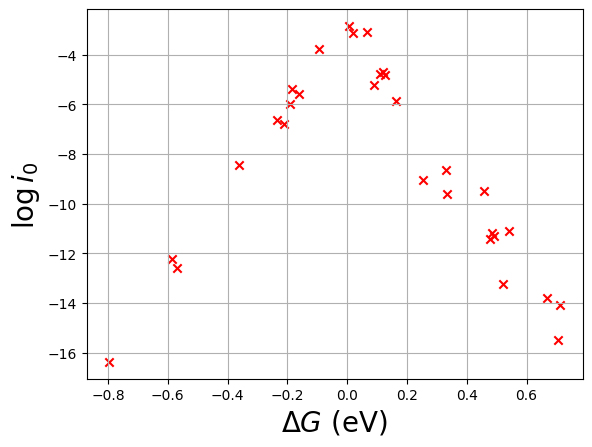

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture6/sabatier_train.csv')

fig,ax = plt.subplots()

def plot_data(ax, df):
  ax.scatter(df['dG (eV)'], df['Log(i0)'], color='r', marker='x', label='actual data')
  ax.set_xlabel('$\\Delta G$ (eV)',fontsize=20)
  ax.set_ylabel('$\\log{i_0}$',fontsize=20)
  ax.grid()

plot_data(ax, df_train)
plt.show()

What we can see is a classic "volcano plot" that exhibits a maximum rate as a function of adsorption energy.  Clearly linear regression is not going to cut it here.  Let's build our data matrix with a linear term in $\Delta G$ and a square term in $\Delta G$.

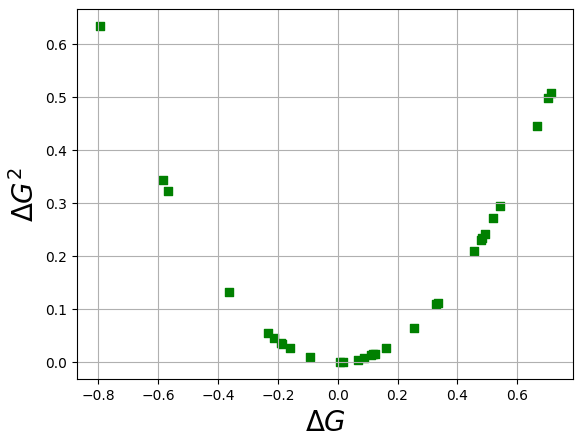

In [ ]:
x = df_train['dG (eV)'].values
X_train = np.column_stack((x, x**2))
y_train = df_train['Log(i0)']

fig,ax = plt.subplots()
ax.scatter(X_train[:,0], X_train[:,1], color='g', marker='s')
ax.set_xlabel('$\\Delta G$',fontsize=20)
ax.set_ylabel('$\\Delta G^{2}$',fontsize=20)
ax.grid()
plt.show()


<code>sklearn</code> also has a <code>polynomial_features</code> function in its <code>preprocessing</code> library, which automates the process of making polynomical features.  This is much more convenient.  We should use <code>include_bias=False</code> because the bias or the intercept will be fit when we do our linear regression.

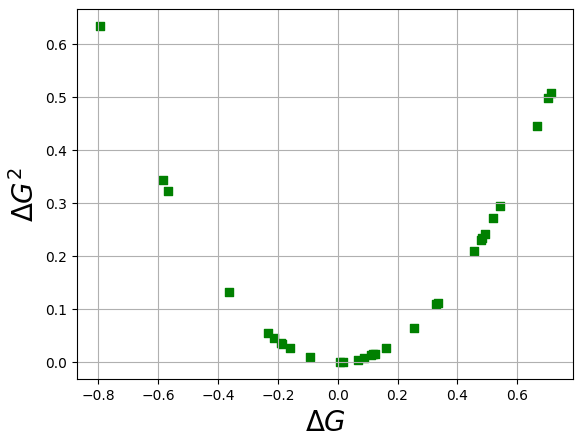

In [ ]:
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)

fig,ax = plt.subplots()
ax.scatter(X_train[:,0], X_train[:,1], color='g', marker='s')
ax.set_xlabel('$\\Delta G$',fontsize=20)
ax.set_ylabel('$\\Delta G^{2}$',fontsize=20)
ax.grid()
plt.show()

Now that we have our polynomial features, we can fit our model just like we did with linear regression.

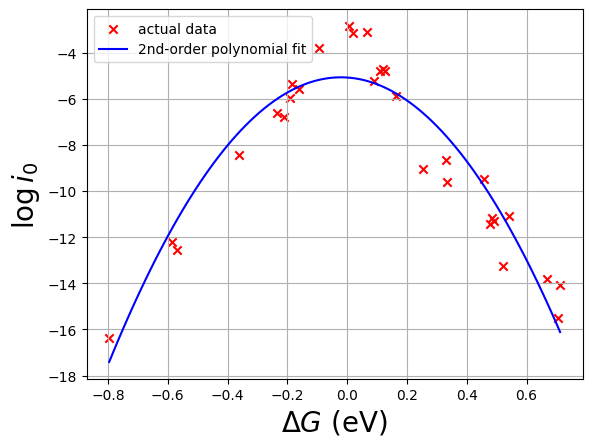

In [ ]:
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

plot_x = np.linspace(np.min(X_train[:,0]), np.max(X_train[:,0]), 100)
plot_x_poly = poly_features.transform(plot_x.reshape(-1,1))
plot_y = model.predict(plot_x_poly)

fig,ax = plt.subplots()
plot_data(ax, df_train)
ax.plot(plot_x, plot_y, color='b', label='2nd-order polynomial fit')
ax.legend()
plt.show()

Let's fit our data to higher orders.  In fact, let's fit our data from every possible order- 1$^st$-order through $(N-1)^{th}$-order, where $N$ is the number of training data points that we have.  We'll calculate the MSE for each model and then plot MSE vs. the order of the polynomial fit at the end.

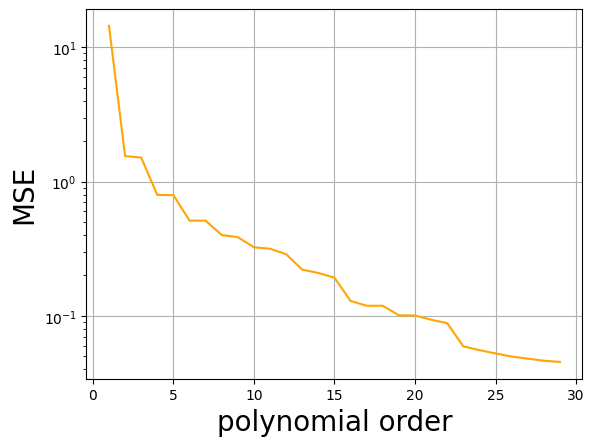

In [ ]:
N = np.arange(1, len(df_train['dG (eV)']))

training_mse = []
for n in N:
  poly_features = sklearn.preprocessing.PolynomialFeatures(degree=n, include_bias=False)
  X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)

  model = sklearn.linear_model.LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_train)
  mse = sklearn.metrics.mean_squared_error(y_train, y_pred)
  training_mse.append(mse)

fig,ax = plt.subplots()
ax.plot(N, training_mse, color='orange')
ax.set_xlabel('polynomial order',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_yscale('log')
ax.grid()
plt.show()

Hey, that looks great.  A high-order polynomial gives us a very low MSE.  Let's take a look at what that model looks like.

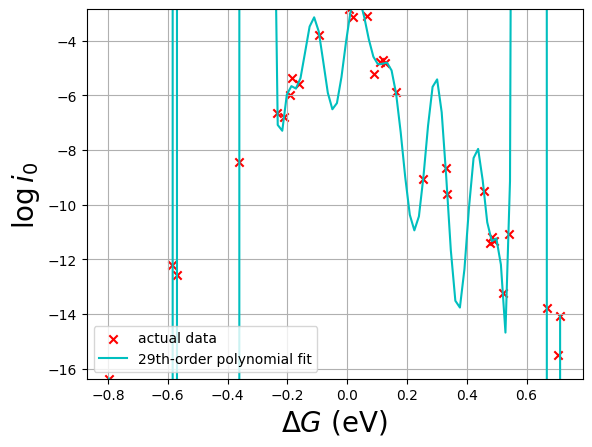

In [ ]:
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=N[-1], include_bias=False)
X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

plot_x = np.linspace(np.min(X_train[:,0]), np.max(X_train[:,0]), 100)
plot_x_poly = poly_features.transform(plot_x.reshape(-1,1))
plot_y = model.predict(plot_x_poly)

fig,ax = plt.subplots()
plot_data(ax, df_train)
ax.plot(plot_x, plot_y, color='c', label=str(N[-1])+'th-order polynomial fit')
ax.set_ylim(np.min(y_train),np.max(y_train))
ax.legend()
plt.show()

Yikes.  Let's check another one.

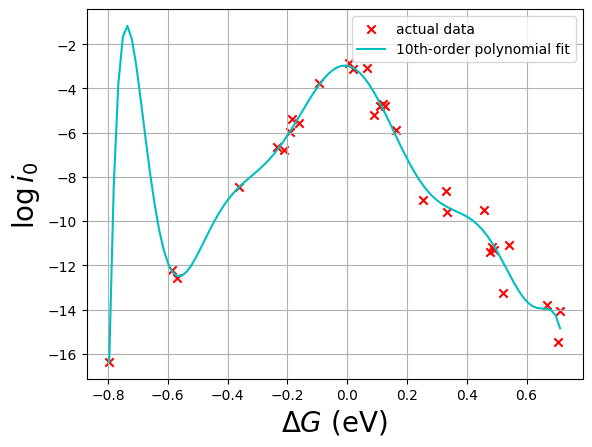

In [ ]:
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=N[-20], include_bias=False)
X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

plot_x = np.linspace(np.min(X_train[:,0]), np.max(X_train[:,0]), 100)
plot_x_poly = poly_features.transform(plot_x.reshape(-1,1))
plot_y = model.predict(plot_x_poly)

fig,ax = plt.subplots()
plot_data(ax, df_train)
ax.plot(plot_x, plot_y, color='c', label=str(N[-20])+'th-order polynomial fit')
ax.legend()
plt.show()

Surely these models don't reflect reality.  Let's go through our exercise of fitting to many polynomial orders, but this time, we'll also look at the *test* MSE, the MSE evaluated on data that wasn't used to train the model.  We'll load in a new data set for the testing.

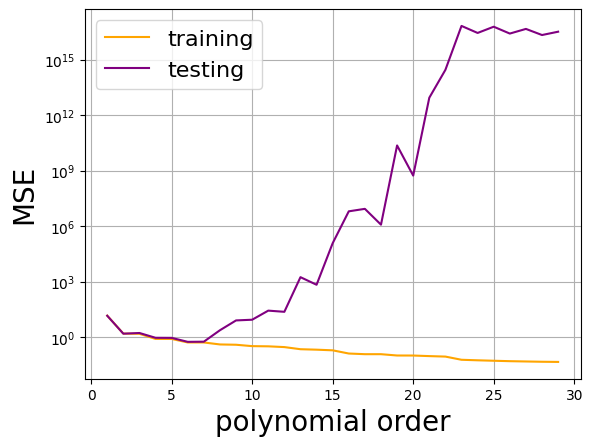

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture6/sabatier_test.csv')
y_test = df_test['Log(i0)']

N = np.arange(1, len(df_train['dG (eV)']))

training_mse = []
testing_mse = []
for n in N:
  poly_features = sklearn.preprocessing.PolynomialFeatures(degree=n, include_bias=False)
  X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)
  X_test = poly_features.transform(df_test[['dG (eV)']].values)

  model = sklearn.linear_model.LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_train)
  mse = sklearn.metrics.mean_squared_error(y_train, y_pred)
  training_mse.append(mse)

  y_pred_test = model.predict(X_test)
  mse = sklearn.metrics.mean_squared_error(y_test, y_pred_test)
  testing_mse.append(mse)

fig,ax = plt.subplots()
ax.plot(N, training_mse, color='orange', label='training')
ax.plot(N, testing_mse, color='purple', label='testing')
ax.set_xlabel('polynomial order',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_yscale('log')
ax.legend(fontsize=16)
ax.grid()
plt.show()

We can see that around a polynomial order of 7 the test MSE reaches a minimum.  Around this point we start fitting intrinsic error in the training data.  Let's take a look at the model with the minimum training error.

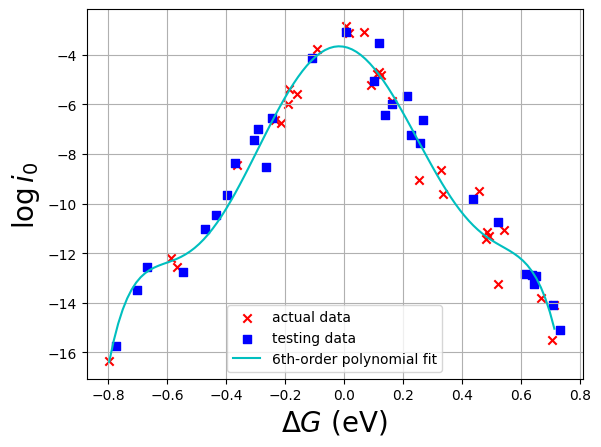

In [ ]:
idx = np.argmin(testing_mse)
n = N[idx]

poly_features = sklearn.preprocessing.PolynomialFeatures(degree=n, include_bias=False)
X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

plot_x = np.linspace(np.min(X_train[:,0]), np.max(X_train[:,0]), 100)
plot_x_poly = poly_features.transform(plot_x.reshape(-1,1))
plot_y = model.predict(plot_x_poly)

fig,ax = plt.subplots()
plot_data(ax, df_train)
ax.scatter(df_test['dG (eV)'], df_test['Log(i0)'], color='b', marker='s', label='testing data')
ax.plot(plot_x, plot_y, color='c', label=str(n)+'th-order polynomial fit')
ax.legend()
plt.show()

This is a much more reasonable model.  And this is a good illustration of the bias-variance tradeoff.  As our model becomes more flexible, its bias will go down- it can fit the data better.  But its variance will increase- it will become more sensitive to changes in the training data.  This is a general principle of machine learning, and we should aim to make our models, as Einstein once said, "as simple as possible, but no simpler."  We should use validation procedures to avoid overfitting.  We'll soon learn about regularization, a way to build models that avoids building in too much variance.